In [1]:
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d robikscube/flight-delay-dataset-20182022

import zipfile
with zipfile.ZipFile('/content/flight-delay-dataset-20182022.zip', 'r') as zip_ref:
    zip_ref.extract('Combined_Flights_2022.parquet', '/content/dataset')

import pandas as pd
df = pd.read_parquet('/content/dataset/Combined_Flights_2022.parquet')
df = df.head(1000000)
# df = pd.read_csv('/content/dataset/Combined_Flights_2022.csv')

Saving kaggle.json to kaggle (1).json
Dataset URL: https://www.kaggle.com/datasets/robikscube/flight-delay-dataset-20182022
License(s): CC0-1.0
flight-delay-dataset-20182022.zip: Skipping, found more recently modified local copy (use --force to force download)


In [2]:
print(df.info())
print(df.head(10).to_string())


<class 'pandas.core.frame.DataFrame'>
Index: 1000000 entries, 0 to 419709
Data columns (total 61 columns):
 #   Column                                   Non-Null Count    Dtype         
---  ------                                   --------------    -----         
 0   FlightDate                               1000000 non-null  datetime64[us]
 1   Airline                                  1000000 non-null  object        
 2   Origin                                   1000000 non-null  object        
 3   Dest                                     1000000 non-null  object        
 4   Cancelled                                1000000 non-null  bool          
 5   Diverted                                 1000000 non-null  bool          
 6   CRSDepTime                               1000000 non-null  int64         
 7   DepTime                                  969126 non-null   float64       
 8   DepDelayMinutes                          969108 non-null   float64       
 9   DepDelay           

# Hapus kolom yang irrelevan

---




In [3]:
dropColumn = [
    "DOT_ID_Marketing_Airline",
    "Marketing_Airline_Network", "IATA_Code_Marketing_Airline",
    "OriginAirportID", "OriginAirportSeqID", "DestAirportID", "DestAirportSeqID",
    "Flight_Number_Operating_Airline","Flight_Number_Marketing_Airline",
    "OriginCityMarketID","DestCityMarketID"
]

df_drop = df.drop(columns=dropColumn)
df_drop.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000000 entries, 0 to 419709
Data columns (total 50 columns):
 #   Column                                   Non-Null Count    Dtype         
---  ------                                   --------------    -----         
 0   FlightDate                               1000000 non-null  datetime64[us]
 1   Airline                                  1000000 non-null  object        
 2   Origin                                   1000000 non-null  object        
 3   Dest                                     1000000 non-null  object        
 4   Cancelled                                1000000 non-null  bool          
 5   Diverted                                 1000000 non-null  bool          
 6   CRSDepTime                               1000000 non-null  int64         
 7   DepTime                                  969126 non-null   float64       
 8   DepDelayMinutes                          969108 non-null   float64       
 9   DepDelay           

# Deteksi sell yang kosong

---



In [4]:
null_counts = df_drop.isnull().sum()
print(null_counts)

FlightDate                                     0
Airline                                        0
Origin                                         0
Dest                                           0
Cancelled                                      0
Diverted                                       0
CRSDepTime                                     0
DepTime                                    30874
DepDelayMinutes                            30892
DepDelay                                   30892
ArrTime                                    31742
ArrDelayMinutes                            33597
AirTime                                    33597
CRSElapsedTime                                 0
ActualElapsedTime                          33597
Distance                                       0
Year                                           0
Quarter                                        0
Month                                          0
DayofMonth                                     0
DayOfWeek           

# Grafik distribusi kepada data kolom yang akan dianalisis

---



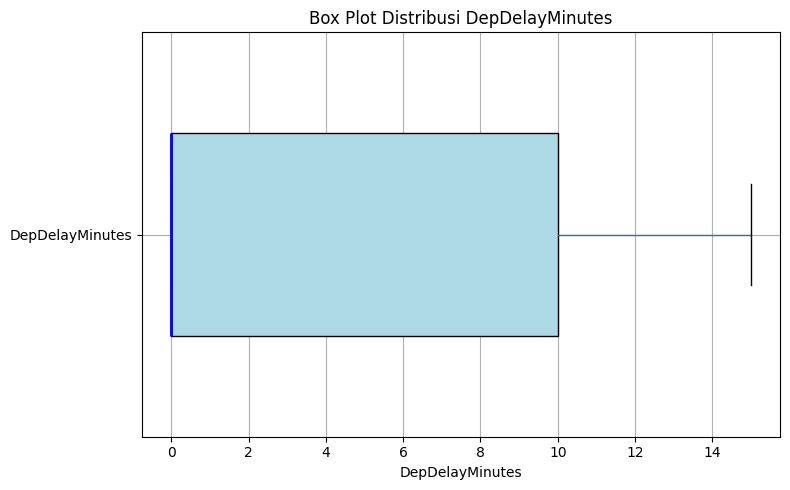

In [5]:
import matplotlib.pyplot as plt

column_to_plot = 'DepDelayMinutes'

fig, ax = plt.subplots(figsize=(8, 5))

df_drop[column_to_plot].plot.box(ax=ax,
                                  patch_artist=True,
                                  showfliers=False,
                                  notch=False,
                                  vert=False,
                                  whis=0.5,
                                  widths=0.5,
                                  boxprops=dict(facecolor='lightblue', color='black'),
                                  capprops=dict(color='black'),
                                  medianprops=dict(color='blue', linewidth=2),
                                  flierprops=dict(marker='o', markerfacecolor='red', markersize=8)
                                 )

ax.grid(True)
ax.set_title(f'Box Plot Distribusi {column_to_plot}')
ax.set_xlabel(column_to_plot)

plt.tight_layout()
plt.show()

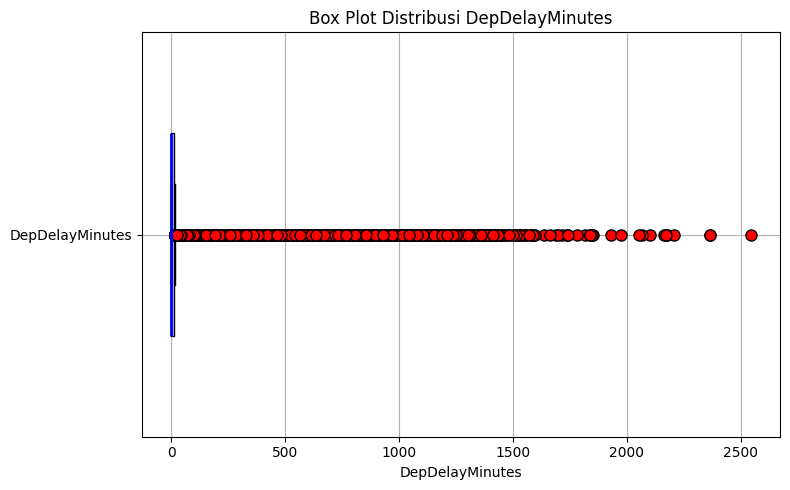

In [6]:
import matplotlib.pyplot as plt

column_to_plot = 'DepDelayMinutes'

fig, ax = plt.subplots(figsize=(8, 5))

df_drop[column_to_plot].plot.box(ax=ax,
                                  patch_artist=True,
                                  showfliers=True,
                                  notch=False,
                                  vert=False,
                                  whis=0.5,
                                  widths=0.5,
                                  boxprops=dict(facecolor='lightblue', color='black'),
                                  capprops=dict(color='black'),
                                  medianprops=dict(color='blue', linewidth=2),
                                  flierprops=dict(marker='o', markerfacecolor='red', markersize=8)
                                 )

ax.grid(True)
ax.set_title(f'Box Plot Distribusi {column_to_plot}')
ax.set_xlabel(column_to_plot)

plt.tight_layout()
plt.show()

In [7]:
df_drop['DepDelayMinutes'].describe()

,DepDelayMinutes
count,969108.000000
mean,15.439390
std,51.141821
min,0.000000
25%,0.000000
50%,0.000000
75%,10.000000
max,2545.000000


In [8]:
df_drop['ArrDelayMinutes'].describe()

,ArrDelayMinutes
count,966403.000000
mean,15.256811
std,50.844300
min,0.000000
25%,0.000000
50%,0.000000
75%,10.000000
max,2600.000000


# Proses data ke PySpark

---



In [9]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Pyspark").getOrCreate()
df_drop.to_parquet('flight_data.parquet', engine='pyarrow')

sdf = spark.read.parquet('flight_data.parquet')
sdf.printSchema()
sdf.show(5)

root
 |-- FlightDate: timestamp_ntz (nullable = true)
 |-- Airline: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Cancelled: boolean (nullable = true)
 |-- Diverted: boolean (nullable = true)
 |-- CRSDepTime: long (nullable = true)
 |-- DepTime: double (nullable = true)
 |-- DepDelayMinutes: double (nullable = true)
 |-- DepDelay: double (nullable = true)
 |-- ArrTime: double (nullable = true)
 |-- ArrDelayMinutes: double (nullable = true)
 |-- AirTime: double (nullable = true)
 |-- CRSElapsedTime: double (nullable = true)
 |-- ActualElapsedTime: double (nullable = true)
 |-- Distance: double (nullable = true)
 |-- Year: long (nullable = true)
 |-- Quarter: long (nullable = true)
 |-- Month: long (nullable = true)
 |-- DayofMonth: long (nullable = true)
 |-- DayOfWeek: long (nullable = true)
 |-- Operated_or_Branded_Code_Share_Partners: string (nullable = true)
 |-- Operating_Airline: string (nullable = true)
 |-- DOT_ID_Operati

# Sebelum normalisasi data kosong

---



In [10]:
from pyspark.sql.functions import isnull, when, count, col

null_counts = sdf.select([count(when(isnull(c), c)).alias(c) for c in sdf.columns])
null_counts.show()

+----------+-------+------+----+---------+--------+----------+-------+---------------+--------+-------+---------------+-------+--------------+-----------------+--------+----+-------+-----+----------+---------+---------------------------------------+-----------------+------------------------+---------------------------+-----------+--------------+-----------+---------------+---------------+---------+------------+---------+-------------+-------------+-------+--------+--------------------+----------+-------+---------+--------+------+----------+--------+--------+------------------+----------+-------------+------------------+-----------------+
|FlightDate|Airline|Origin|Dest|Cancelled|Diverted|CRSDepTime|DepTime|DepDelayMinutes|DepDelay|ArrTime|ArrDelayMinutes|AirTime|CRSElapsedTime|ActualElapsedTime|Distance|Year|Quarter|Month|DayofMonth|DayOfWeek|Operated_or_Branded_Code_Share_Partners|Operating_Airline|DOT_ID_Operating_Airline|IATA_Code_Operating_Airline|Tail_Number|OriginCityName|OriginS

In [11]:
from pyspark.ml.feature import Imputer

numerical_cols = [col_name for col_name, col_type in sdf.dtypes if col_type in ["int", "double", "float"]]
categorical_cols = [col_name for col_name, col_type in sdf.dtypes if col_type not in ["int", "double", "float"] and col_name != "Tail_Number"]

#Numerik
imputer = Imputer(inputCols=numerical_cols,
                  outputCols=numerical_cols,
                  strategy="median")
imputer = imputer.fit(sdf)
sdf_clean = imputer.transform(sdf)

#Kategori
from pyspark.sql.functions import when, isnull, count, col

for cat_col in categorical_cols:
  mode_value = sdf_clean.groupBy(cat_col).count().orderBy(col("count").desc()).first()[0]
  sdf_clean = sdf_clean.withColumn(cat_col, when(isnull(cat_col), mode_value).otherwise(col(cat_col)))

sdf_clean = sdf_clean.fillna("Unknown", subset=["Tail_Number"])


# Setelah normalisasi

---



In [12]:
from pyspark.sql.functions import isnull, when, count, col

null_counts = sdf_clean.select([count(when(isnull(c), c)).alias(c) for c in sdf_clean.columns])
null_counts.show()


+----------+-------+------+----+---------+--------+----------+-------+---------------+--------+-------+---------------+-------+--------------+-----------------+--------+----+-------+-----+----------+---------+---------------------------------------+-----------------+------------------------+---------------------------+-----------+--------------+-----------+---------------+---------------+---------+------------+---------+-------------+-------------+-------+--------+--------------------+----------+-------+---------+--------+------+----------+--------+--------+------------------+----------+-------------+------------------+-----------------+
|FlightDate|Airline|Origin|Dest|Cancelled|Diverted|CRSDepTime|DepTime|DepDelayMinutes|DepDelay|ArrTime|ArrDelayMinutes|AirTime|CRSElapsedTime|ActualElapsedTime|Distance|Year|Quarter|Month|DayofMonth|DayOfWeek|Operated_or_Branded_Code_Share_Partners|Operating_Airline|DOT_ID_Operating_Airline|IATA_Code_Operating_Airline|Tail_Number|OriginCityName|OriginS

# Persiapan data sebelum diproses model

---



**Penerapan logaritma pada kolom data untuk input machine learning yang lebih baik**

In [13]:
delay_columns = [
    "DepDelayMinutes", "CRSDepTime", "CRSElapsedTime", "Distance",
    "TaxiOut", "TaxiIn", "Airline", "Origin", "Dest", "DayOfWeek", "Month","Tail_Number",
    "DOT_ID_Operating_Airline"
]
delay_data = sdf_clean.select(*delay_columns)
delay_data.select("DepDelayMinutes").summary().show()


+-------+-----------------+
|summary|  DepDelayMinutes|
+-------+-----------------+
|  count|          1000000|
|   mean|        14.962436|
| stddev|50.41651061676754|
|    min|              0.0|
|    25%|              0.0|
|    50%|              0.0|
|    75%|              9.0|
|    max|           2545.0|
+-------+-----------------+



In [14]:
from pyspark.sql import functions as F

percentile_95_dep = delay_data.approxQuantile("DepDelayMinutes", [0.95], 0.01)[0]

delay_data_log = delay_data.withColumn("DepDelayMinutes",
                                   F.when(F.col("DepDelayMinutes") > percentile_95_dep, percentile_95_dep)
                                   .otherwise(F.col("DepDelayMinutes")))

delay_data_log.show(5)

+---------------+----------+--------------+--------+-------+------+--------------------+------+----+---------+-----+-----------+------------------------+
|DepDelayMinutes|CRSDepTime|CRSElapsedTime|Distance|TaxiOut|TaxiIn|             Airline|Origin|Dest|DayOfWeek|Month|Tail_Number|DOT_ID_Operating_Airline|
+---------------+----------+--------------+--------+-------+------+--------------------+------+----+---------+-----+-----------+------------------------+
|            0.0|      1133|          72.0|   212.0|   17.0|   8.0|Commutair Aka Cha...|   GJT| DEN|        1|    4|     N21144|                   20445|
|            0.0|       732|          77.0|   295.0|   16.0|   9.0|Commutair Aka Cha...|   HRL| IAH|        1|    4|     N16170|                   20445|
|            0.0|      1529|          70.0|   251.0|   21.0|  14.0|Commutair Aka Cha...|   DRO| DEN|        1|    4|     N21144|                   20445|
|            0.0|      1435|          90.0|   376.0|   16.0|   4.0|Commutair

In [15]:
delay_data_log = delay_data_log.withColumn("HourOfDay", (F.col("CRSDepTime") / 100).cast("int"))
delay_data_log = delay_data_log.withColumn("IsPeakHours",
                                           F.when((F.col("HourOfDay") >= 7) & (F.col("HourOfDay") <= 10), 1)
                                           .when((F.col("HourOfDay") >= 16) & (F.col("HourOfDay") <= 19), 1)
                                           .otherwise(0))

delay_data_log = delay_data_log.withColumn("Speed", F.col("Distance") / F.col("CRSElapsedTime"))

delay_data_log = delay_data_log.withColumn("Airline-Origin", F.concat_ws("-", F.col("Airline"), F.col("Origin")))


In [16]:
delay_data_log.printSchema()

root
 |-- DepDelayMinutes: double (nullable = true)
 |-- CRSDepTime: long (nullable = true)
 |-- CRSElapsedTime: double (nullable = true)
 |-- Distance: double (nullable = true)
 |-- TaxiOut: double (nullable = true)
 |-- TaxiIn: double (nullable = true)
 |-- Airline: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- DayOfWeek: long (nullable = true)
 |-- Month: long (nullable = true)
 |-- Tail_Number: string (nullable = false)
 |-- DOT_ID_Operating_Airline: long (nullable = true)
 |-- HourOfDay: integer (nullable = true)
 |-- IsPeakHours: integer (nullable = false)
 |-- Speed: double (nullable = true)
 |-- Airline-Origin: string (nullable = false)



**Mengubah kolom kategori menjadi data index**

In [17]:
from pyspark.ml.feature import StringIndexer

categorical_columns = ["Airline", "Origin", "Dest","Tail_Number",
                       "Airline-Origin"]

from pyspark.ml.feature import VectorAssembler, StandardScaler

#Proses Vektorisasi Kolom Numerik
numeric_columns = [x for x in delay_data_log.columns if x not in categorical_columns]
delay_assembler = VectorAssembler(inputCols=numeric_columns, outputCol="numeric_features")
delay_data_log = delay_assembler.transform(delay_data_log)

#Proses Standarisasi Skala Kolom Numerik
delay_scaler = StandardScaler(inputCol="numeric_features", outputCol="scaled_numeric_features", withMean=True, withStd=True)
delay_scaler_model = delay_scaler.fit(delay_data_log)
delay_data_log = delay_scaler_model.transform(delay_data_log)



#Proses Mengubah Kolom berkategori menjadi index
for col_name in categorical_columns:
    indexer = StringIndexer(inputCol=col_name, outputCol=f"{col_name}_Indexed")
    indexer_model = indexer.fit(delay_data_log)
    delay_data_log = indexer_model.transform(delay_data_log)
    indexer_model.write().overwrite().save(f"{col_name}_indexer_model")

#Proses Mengubah Kolom-Kolom Index Kategori Menjadi One Hot Encoder
from pyspark.ml.feature import OneHotEncoder

categorical_columns_indexed = [f"{x}_Indexed" for x in categorical_columns]
for col_name in categorical_columns_indexed:
    one_hot_encoder = OneHotEncoder(inputCol=col_name, outputCol=f'{col_name}_OneHot')
    delay_data_log = one_hot_encoder.fit(delay_data_log).transform(delay_data_log)

In [18]:
delay_data_log.show(5)
delay_data_log.select('scaled_numeric_features').take(3)

+---------------+----------+--------------+--------+-------+------+--------------------+------+----+---------+-----+-----------+------------------------+---------+-----------+------------------+--------------------+--------------------+-----------------------+---------------+--------------+------------+-------------------+----------------------+----------------------+---------------------+-------------------+--------------------------+-----------------------------+
|DepDelayMinutes|CRSDepTime|CRSElapsedTime|Distance|TaxiOut|TaxiIn|             Airline|Origin|Dest|DayOfWeek|Month|Tail_Number|DOT_ID_Operating_Airline|HourOfDay|IsPeakHours|             Speed|      Airline-Origin|    numeric_features|scaled_numeric_features|Airline_Indexed|Origin_Indexed|Dest_Indexed|Tail_Number_Indexed|Airline-Origin_Indexed|Airline_Indexed_OneHot|Origin_Indexed_OneHot|Dest_Indexed_OneHot|Tail_Number_Indexed_OneHot|Airline-Origin_Indexed_OneHot|
+---------------+----------+--------------+--------+-------+

[Row(scaled_numeric_features=DenseVector([-0.496, -0.3973, -0.9749, -1.005, 0.0234, 0.0694, -1.528, 0.8505, 1.2268, -0.4111, -0.9764, -1.4913])),
 Row(scaled_numeric_features=DenseVector([-0.496, -1.2168, -0.9049, -0.8631, -0.0843, 0.2322, -1.528, 0.8505, 1.2268, -1.2324, 1.0242, -0.8769])),
 Row(scaled_numeric_features=DenseVector([-0.496, 0.412, -1.0029, -0.9383, 0.454, 1.0463, -1.528, 0.8505, 1.2268, 0.4102, -0.9764, -1.047]))]

**Standarisasi data**

In [19]:
categorical_columns_indexed = [f"{x}_Indexed_OneHot" for x in categorical_columns]

final_features = ['scaled_numeric_features']+categorical_columns_indexed

assembler = VectorAssembler(inputCols=final_features,
                            outputCol='final_feature_vector')

delay_data_log = assembler.transform(delay_data_log)
delay_data_log.show(3)

+---------------+----------+--------------+--------+-------+------+--------------------+------+----+---------+-----+-----------+------------------------+---------+-----------+------------------+--------------------+--------------------+-----------------------+---------------+--------------+------------+-------------------+----------------------+----------------------+---------------------+-------------------+--------------------------+-----------------------------+--------------------+
|DepDelayMinutes|CRSDepTime|CRSElapsedTime|Distance|TaxiOut|TaxiIn|             Airline|Origin|Dest|DayOfWeek|Month|Tail_Number|DOT_ID_Operating_Airline|HourOfDay|IsPeakHours|             Speed|      Airline-Origin|    numeric_features|scaled_numeric_features|Airline_Indexed|Origin_Indexed|Dest_Indexed|Tail_Number_Indexed|Airline-Origin_Indexed|Airline_Indexed_OneHot|Origin_Indexed_OneHot|Dest_Indexed_OneHot|Tail_Number_Indexed_OneHot|Airline-Origin_Indexed_OneHot|final_feature_vector|
+---------------+-

In [20]:
delay_data_log.select('final_feature_vector').take(3)

[Row(final_feature_vector=SparseVector(8408, {0: -0.496, 1: -0.3973, 2: -0.9749, 3: -1.005, 4: 0.0234, 5: 0.0694, 6: -1.528, 7: 0.8505, 8: 1.2268, 9: -0.4111, 10: -0.9764, 11: -1.4913, 31: 1.0, 196: 1.0, 401: 1.0, 4942: 1.0, 7965: 1.0})),
 Row(final_feature_vector=SparseVector(8408, {0: -0.496, 1: -1.2168, 2: -0.9049, 3: -0.8631, 4: -0.0843, 5: 0.2322, 6: -1.528, 7: 0.8505, 8: 1.2268, 9: -1.2324, 10: 1.0242, 11: -0.8769, 31: 1.0, 190: 1.0, 414: 1.0, 4828: 1.0, 7973: 1.0})),
 Row(final_feature_vector=SparseVector(8408, {0: -0.496, 1: 0.412, 2: -1.0029, 3: -0.9383, 4: 0.454, 5: 1.0463, 6: -1.528, 7: 0.8505, 8: 1.2268, 9: 0.4102, 10: -0.9764, 11: -1.047, 31: 1.0, 197: 1.0, 401: 1.0, 4942: 1.0, 7784: 1.0}))]

In [21]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
import pyspark.sql.functions as F

# Apply log transformation to DepDelayMinutes
delay_data_log = delay_data_log.withColumn("log_DepDelayMinutes", F.log1p("DepDelayMinutes"))

# Split data into training and testing sets
delay_train, delay_test = delay_data_log.randomSplit([0.8, 0.2], seed=42)

# Define and train the linear regression model on log-transformed data
lr_DepDelay = LinearRegression(featuresCol='final_feature_vector', labelCol='log_DepDelayMinutes')
lr_DepDelay_model = lr_DepDelay.fit(delay_train)

# Predict log-transformed values and back-transform to original scale
predictions_dep = lr_DepDelay_model.transform(delay_test) \
    .withColumn("predicted_DepDelayMinutes", F.expm1("prediction"))

# Evaluate model performance on original scale
evaluator = RegressionEvaluator(
    labelCol="DepDelayMinutes",
    predictionCol="predicted_DepDelayMinutes",
    metricName="rmse"
)
rmse = evaluator.evaluate(predictions_dep)
print(f"Model RMSE on Original Scale: {rmse}")


Model RMSE on Original Scale: 34.07061838253077


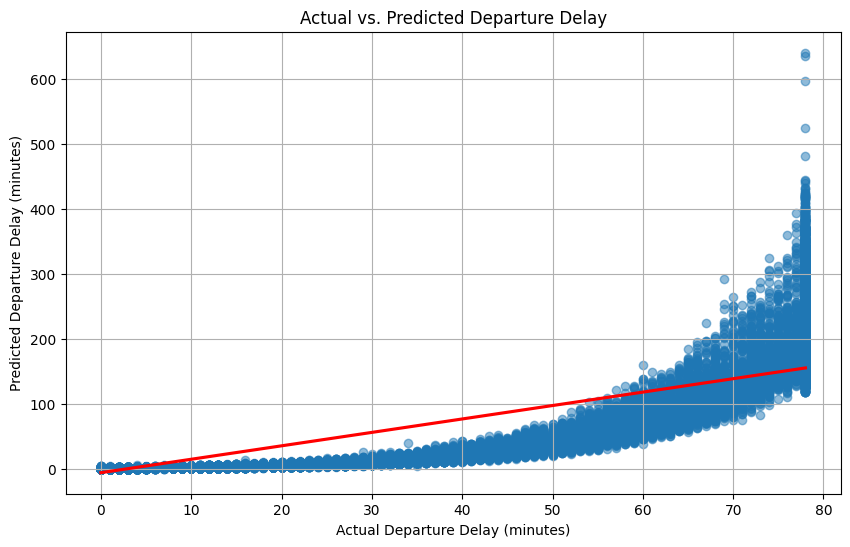

In [22]:
import seaborn as sns

dep_pd = predictions_dep.select("DepDelayMinutes", "predicted_DepDelayMinutes").toPandas()

# Departure Delay Plot
plt.figure(figsize=(10, 6))
sns.regplot(x="DepDelayMinutes", y="predicted_DepDelayMinutes", data=dep_pd,
            scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.xlabel("Actual Departure Delay (minutes)")
plt.ylabel("Predicted Departure Delay (minutes)")
plt.title("Actual vs. Predicted Departure Delay")
plt.grid(True)
plt.show()

In [23]:
predDep_cross = predictions_dep[['predicted_DepDelayMinutes',
                                        'DepDelayMinutes']]

predDep_cross = predDep_cross.rdd
predDep_cross = predDep_cross.map(tuple)
from pyspark.mllib.evaluation import RegressionMetrics

metrics = RegressionMetrics(predDep_cross)

s = '''
Mean Squared Error:      {0}
Root Mean Squared Error: {1}
Mean Absolute Error:     {2}
R**2:                    {3}
'''.format(metrics.meanSquaredError,
           metrics.rootMeanSquaredError,
           metrics.meanAbsoluteError,
           metrics.r2
           )

print(s)

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(



Mean Squared Error:      1160.8070369680433
Root Mean Squared Error: 34.07061838253077
Mean Absolute Error:     11.034263200738966
R**2:                    -1.611190321653278





---



---



---



---



---



# **hyperparameter**




In [ ]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
import pyspark.sql.functions as F

# Step 1: Log-transform the target column
delay_data_log = delay_data_log.withColumn("log_DepDelayMinutes", F.log1p("DepDelayMinutes"))

# Step 2: Split data into training and testing sets
delay_train, delay_test = delay_data_log.randomSplit([0.8, 0.2], seed=42)

# Step 3: Define the linear regression model
lr = LinearRegression(featuresCol='final_feature_vector', labelCol='log_DepDelayMinutes')

# Step 4: Define hyperparameter grid
paramGrid = (ParamGridBuilder()
    .addGrid(lr.regParam, [0.001, 0.01, 0.1, 0.5, 1.0])  # Regularization strength
    .addGrid(lr.elasticNetParam, [0.0, 0.25, 0.5, 0.75, 1.0])  # Ridge-Lasso mixing
    .addGrid(lr.fitIntercept, [True, False])  # Fit intercept or not
    .build())

# Step 5: Define the evaluator (evaluate on the original scale)
evaluator = RegressionEvaluator(labelCol="DepDelayMinutes", predictionCol="prediction", metricName="rmse")

# Step 6: Set up cross-validation
cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)  # 5-fold cross-validation

# Step 7: Train the model
cvModel = cv.fit(delay_train)

# Step 8: Predict and back-transform
predictions_dep = cvModel.bestModel.transform(delay_test).withColumn("predicted_DepDelayMinutes", F.expm1("prediction"))

# Step 9: Evaluate the model
rmse = evaluator.evaluate(predictions_dep)
print(f"Best Model RMSE on Original Scale: {rmse}")

# Step 10: Extract best hyperparameters
print("Best Hyperparameters:")
print(f" regParam: {cvModel.bestModel._java_obj.getRegParam()}")
print(f" elasticNetParam: {cvModel.bestModel._java_obj.getElasticNetParam()}")
print(f" fitIntercept: {cvModel.bestModel._java_obj.getFitIntercept()}")


In [ ]:
# from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
# from pyspark.sql import functions as F

# # Example simplified test data for prediction (new flight)
# Simulasi = {
#     "DepDelayMinutes": 0,
#     "CRSDepTime": 1000,
#     "CRSElapsedTime": 90,
#     "Distance":500,
#     "TaxiOut": 15,
#     "TaxiIn": 5,
#     "DayOfWeek": 5,  # Example: Wednesday
#     "Month": 7,  # Example: July
#     "Airline": "Commutair Aka Champlain Enterprises, Inc.",  # Example airline
#     "Origin": "JFK",  # Example origin airport
#     "Dest": "LAX",  # Example destination airport
#     "Tail_Number": "N21144",  # Example Tail Number
#     "Operated_or_Branded_Code_Share_Partners": "UA_CODESHARE",
#     "DOT_ID_Operating_Airline": 20445
# }

# Simulasi_log = spark.createDataFrame([Simulasi])


# Simulasi_log = Simulasi_log.withColumn("HourOfDay", (F.col("CRSDepTime") / 100).cast("int"))
# Simulasi_log = Simulasi_log.withColumn("IsPeakHours",
#                                            F.when((F.col("HourOfDay") >= 7) & (F.col("HourOfDay") <= 10), 1)
#                                            .when((F.col("HourOfDay") >= 16) & (F.col("HourOfDay") <= 19), 1)
#                                            .otherwise(0))

# Simulasi_log = Simulasi_log.withColumn("Speed", F.col("Distance") / F.col("CRSElapsedTime"))

# Simulasi_log = Simulasi_log.withColumn("Airline-Origin", F.concat_ws("-", F.col("Airline"), F.col("Origin")))

# categorical_columns = ["Airline", "Origin", "Dest","Tail_Number",
#                        "Operated_or_Branded_Code_Share_Partners",
#                        "Airline-Origin"]

# observed_column = ['DepDelayMinutes']

# numeric_columns = [x for x in Simulasi_log.columns if x not in categorical_columns + observed_column]
# delay_assembler = VectorAssembler(inputCols=numeric_columns, outputCol="numeric_features")
# Simulasi_log = delay_assembler.transform(Simulasi_log)

# delay_scaler = StandardScaler(inputCol="numeric_features", outputCol="scaled_features", withMean=True, withStd=True)
# delay_scaler_model = delay_scaler.fit(Simulasi_log)
# Simulasi_log = delay_scaler_model.transform(Simulasi_log)

# # delay_data_log = delay_data_log.drop(*numeric_columns)

# from pyspark.ml.feature import StringIndexerModel

# # Apply the saved StringIndexerModel to new data
# for col_name in categorical_columns:
#     indexer_model = StringIndexerModel.load(f"{col_name}_indexer_model")  # Load fitted model
#     # Set handleInvalid to "keep" to handle unseen labels
#     indexer_model.setHandleInvalid("keep")
#     Simulasi_log = indexer_model.transform(Simulasi_log)  # Apply transformation to new data

# # delay_data_log = delay_data_log.drop(*categorical_columns)

# from pyspark.ml.feature import OneHotEncoder

# categorical_columns_indexed = [f"{x}_Indexed" for x in categorical_columns]

# for col_name in categorical_columns_indexed:
#     one_hot_encoder = OneHotEncoder(inputCol=col_name, outputCol=f'{col_name}_OneHot')
#     Simulasi_log = one_hot_encoder.fit(Simulasi_log).transform(Simulasi_log)

# final_features = ['scaled_features']+categorical_columns_indexed

# assembler = VectorAssembler(inputCols=final_features,
#                             outputCol='final_feature_vector')

# Simulasi_log = assembler.transform(Simulasi_log)
# Simulasi_log.show(3)

# Simulasi_log.select('final_feature_vector').take(3)

In [ ]:
# # Step 6: Predict the delay using the trained model (best_model should already be defined)
# predicted_dep_delay = best_model.transform(Simulasi_log) \
#     .withColumnRenamed('prediction', 'predicted_DepDelayMinutes')  # Convert log-transformed prediction back to original scale

# # Show the predicted results
# predicted_dep_delay.select("Airline", "Origin", "Dest", "predicted_DepDelayMinutes").show()

